In [1]:
#Import packages
#---------------------------------------
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
import ants
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

#Import your modules
#---------------------------------------
import admin_functions as adfn
import register as rfn

# Define paths
#----------------------------------------------------------------------
Fcode = '/Users/dominicburrows/Dropbox/PhD/Analysis/my_scripts/GitHub/'
Fdata = '/Users/dominicburrows/Dropbox/PhD/analysis/Project/'
Fdoc = '/Users/dominicburrows/Documents/'
F10t = '/Volumes/Dominic 10tb/Data2process/Project/' 
F10t2 = '/Volumes/Dominic 10tb2/Data2process/Project/'
Ftm = '/Volumes/Dominic Time Machine/'
Ffig = '/Users/dominicburrows/Dropbox/PhD/figures/'

%load_ext autoreload
sys.version

'3.7.6 (default, Jan  8 2020, 13:42:34) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

# Load atlas data

In [3]:
# Load zebrafish brain browser images and format 
#-----------------------------------------------------------------------------------
Fzbb = '/Users/dominicburrows/Dropbox/PhD/analysis' + '/' + 'zbrain_stacks/'
zbb1 = ants.image_read(Fzbb + os.sep + 'Misc/huC-h2b-RFP.tif')     
zbb1.set_spacing([.3,.3,1.])
zbb  = (zbb1 / np.amax(zbb1.numpy()))
zbb.set_spacing([.3,.3,1.])

# Load genetic atlas labels and format (already in zbb space)
#-----------------------------------------------------------------------------------
Fzbb = '/Users/dominicburrows/Dropbox/PhD/analysis/' + 'zbrain_stacks/'
atlasim = Fzbb + 'atlas/pajevic1.tif'
atlasli = Fzbb + 'atlas/Pajevic_annotations.csv'
atlaslab=pd.read_csv(atlasli, sep=',',header=None)
label = ants.image_read(atlasim)
label.set_spacing([1.2,1.2,4.])

# Load kunst
#-----------------------------------------------------------------------------------
kb = ants.image_read(Fzbb + os.sep + 'kunst/T_AVG_H2BGCaMP_H2BGCaMP.tif') 
kb.set_direction(np.array([[0,1.,0.],[1.,0.,0.],[0.,0.,-1.]])) 
kb.set_spacing([.3,.3,1])

In [3]:
#Load traced neurons in standard space
#-----------------------------------------------------------------------------------
conn_list = adfn.return_files(Fdata, 'PTZ-WILDTYPE', '*atlas*')
kmeans_list = adfn.return_files(Fdata, 'PTZ-WILDTYPE', '*Ahrens*')

import pandas as pd
coords = pd.read_csv(conn_list[0])
coords

ID     start_x     start_y     start_z      stop_x      stop_y  \
0         1  419.605743  372.904877  208.815018  405.110321  352.853363   
1         1  419.605743  372.904877  208.815018  401.367859  341.110229   
2         1  419.605743  372.904877  208.815018  401.930298  335.409088   
3         1  419.605743  372.904877  208.815018  411.859863  343.718719   
4         1  419.605743  372.904877  208.815018  419.022858  348.411011   
...     ...         ...         ...         ...         ...         ...   
81277  3119  260.879578  234.483383  106.049133  229.904556  214.334442   
81278  3119  260.879578  234.483383  106.049133  238.541321  210.633423   
81279  3119  260.879578  234.483383  106.049133  243.640427  223.822769   
81280  3119  260.879578  234.483383  106.049133  217.230270  240.188019   
81281  3119  260.879578  234.483383  106.049133  223.145920  245.975769   

           stop_z  
0      197.227615  
1      212.254959  
2      213.875122  
3      214.643921  
4      217.191559  
...           ...  
81277  110.568687  
81278   82.402649  
81279   98.493629  
81280   95.431923  
81281  100.079201  

[81282 rows x 7 columns]

# Pre-process image

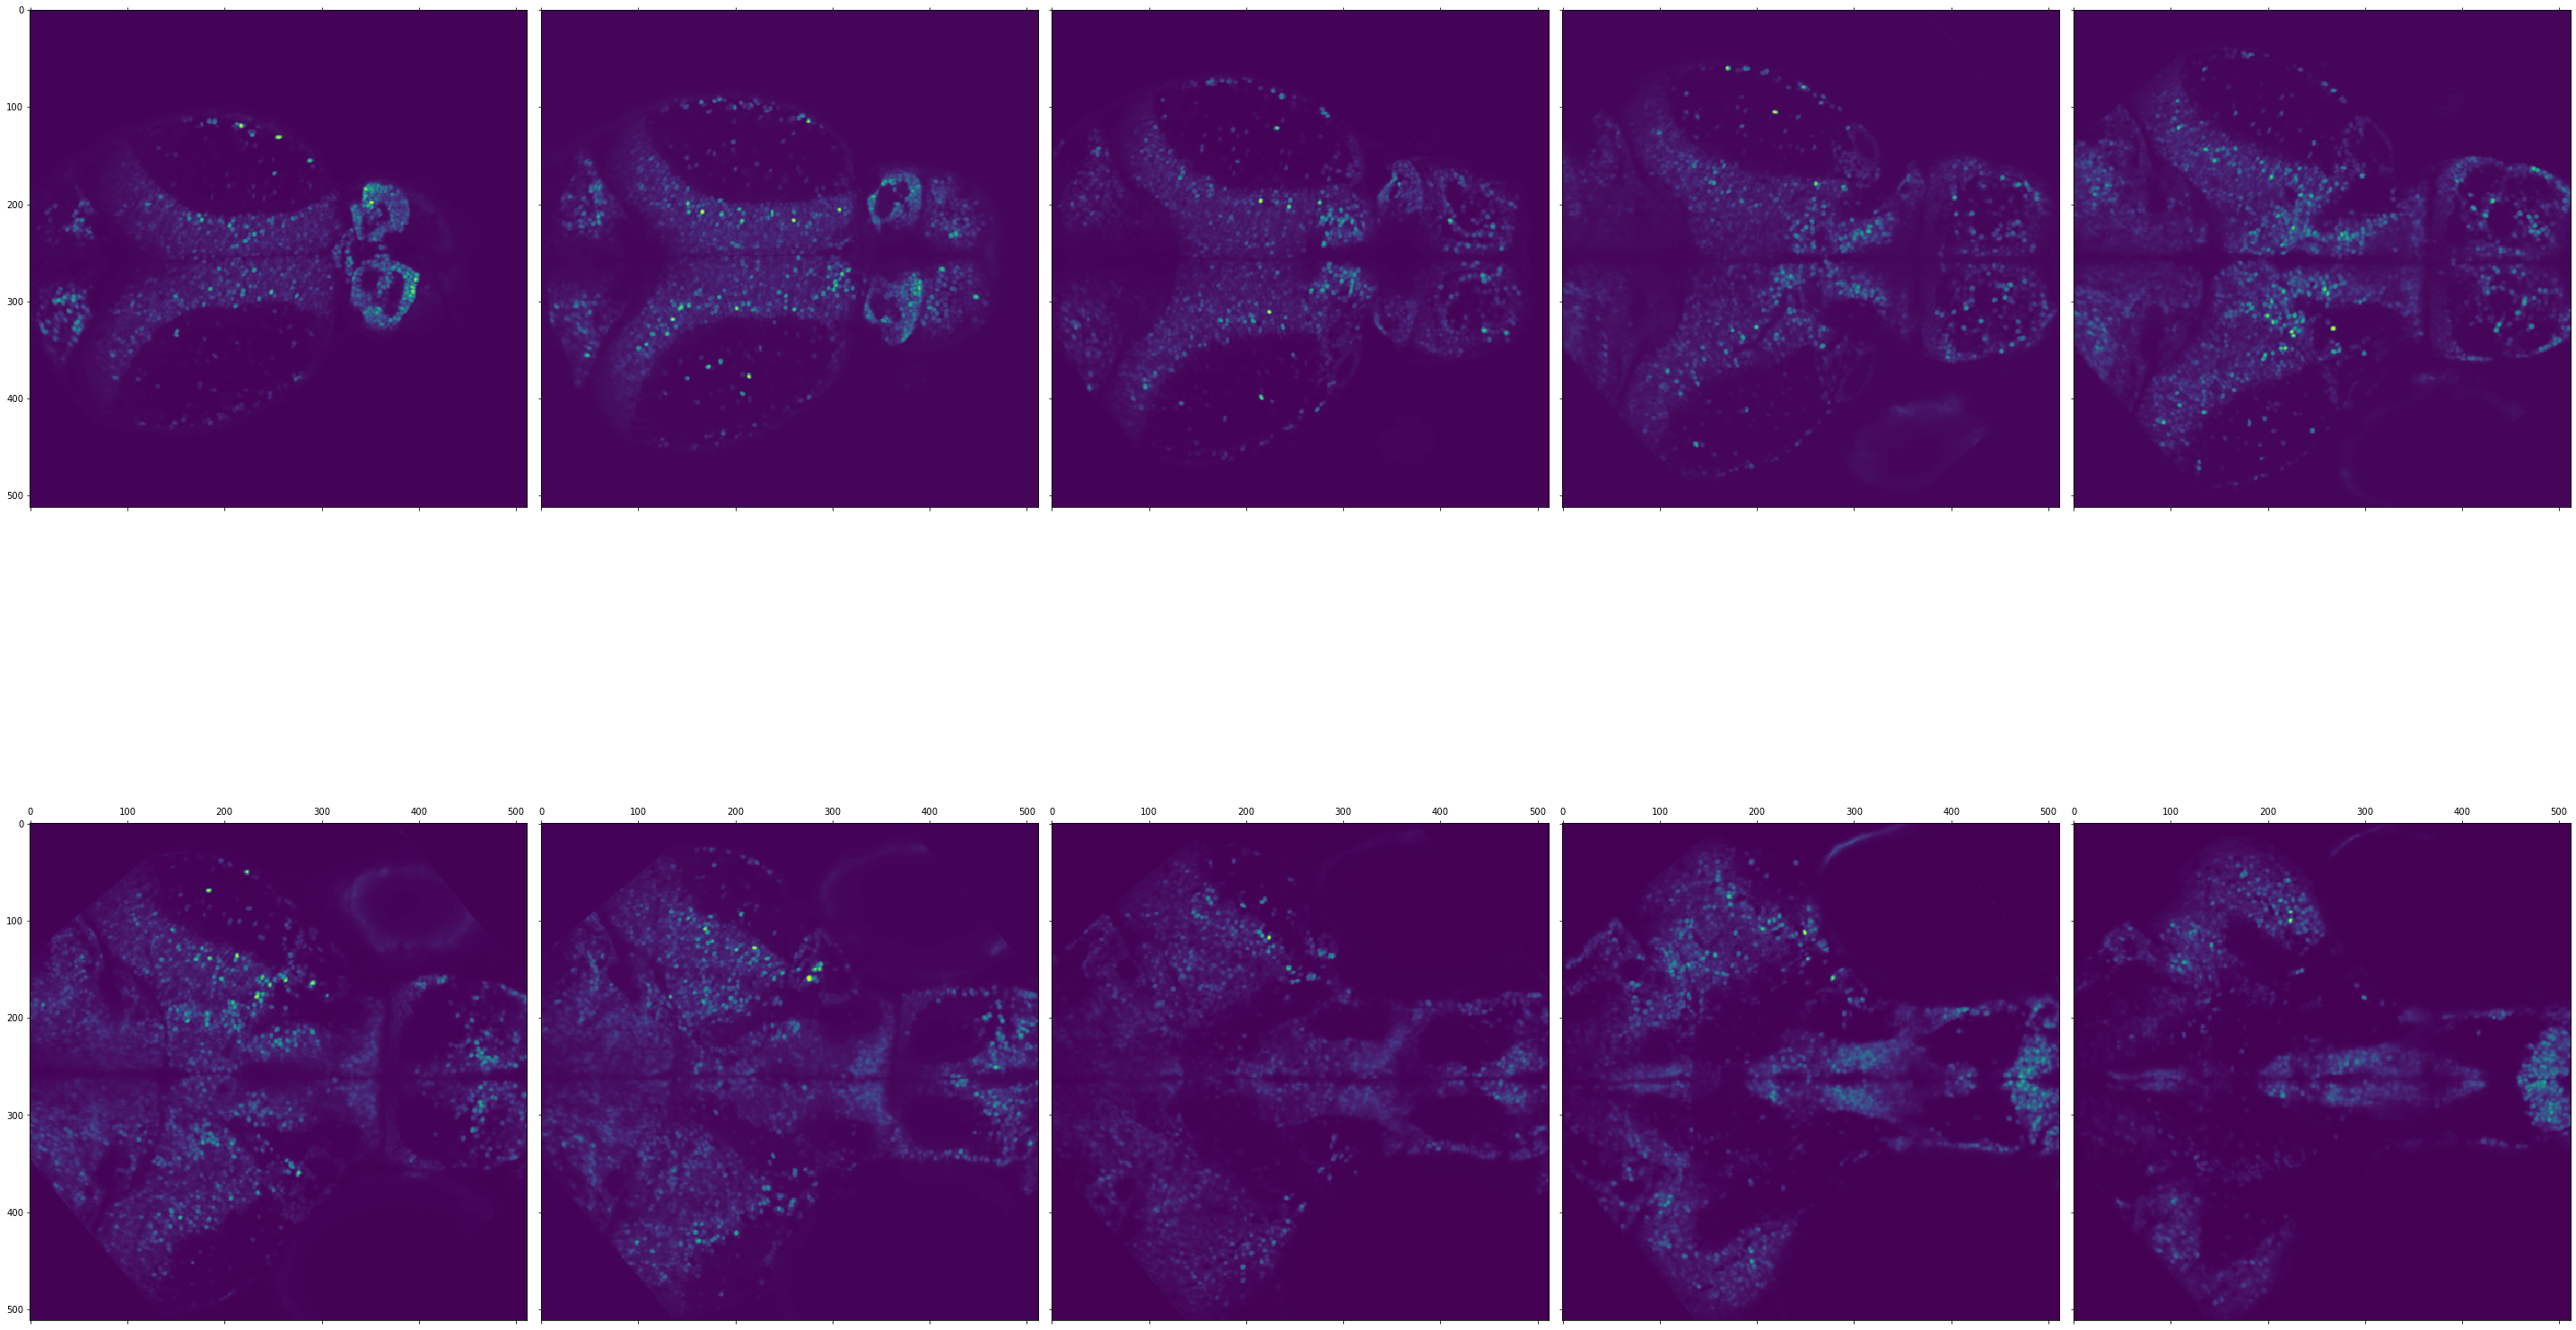

In [27]:
#Select fish to visualise
#-------------------------------------------------------------
experiment = 'PTZ-WILDTYPE-15'    #Subfolder name
img_type = '/2photon/sess-01-6dpf/'       #add dpf
disk = '/Volumes/Dominic Time Machine/'          #path to ops files
condition = 'PTZ05_'                      #experiment condition - BE SURE TO ADD _ AT END


ops_list = adfn.return_files(disk + 'Project/', experiment + img_type, '*' + condition + '*ops.npy')
if len(ops_list) > 10:
    print('There are more than 10 planes - check you are loading one fish')
    
# Rotate image - select correct orientation for registration
#----------------------------------------------------------------
degree=220
Frotate = rfn.rotate(disk + 'Project/' + experiment + img_type, ops_list, degree)

In [28]:
# Save as multipage tif - for registration
#-----------------------------------------
Frotate_save = rfn.savemeanimg(disk + 'Project/' + experiment + img_type, ops_list, Frotate, degree)

# Batch register

In [35]:
#Select fish path
#-----------------------------------------
experiment = 'PTZ-WILDTYPE'
disk = '/Volumes/Dominic Time Machine/'          #path to ops files
cond_list = ['BLN_', 'PTZ05_', 'PTZ20_' ] #ADD _ AT END
#cond_list = ['BLNLIGHT_', 'PTZ02_'] 
modality = '2photon'
prefix = None #Set to Yes if genotype is present in name

#Select reg params
#-----------------------------------------
reg_type = 'SyNRA' #SyNRA gives best results
mode = 'check' #Set to check if you want to visualise output

#Check files
#-----------------------------------------
file_list = adfn.return_files(disk, '/Project/', experiment + '**')[11:13]
file_list

['PTZ-WILDTYPE-13', 'PTZ-WILDTYPE-14']

In [ ]:
#Run
#-----------------------------------------
for file in file_list:
    for cond in cond_list:

        #Load image file and trace data 
        moving, Fish, img_fold, savename  = rfn.load_prereg(experiment, file, modality, cond, prefix, disk, Fdata)
        
        #Perform registration and pull out labels
        reg_coord, lab_coord, reg_trace, reg_bind, reg_dff = rfn.reg_label(zbb,
                                                                           moving, 
                                                                           label, 
                                                                           atlaslab, 
                                                                           Fish['coord'], 
                                                                           Fish['trace'], 
                                                                           Fish['dff'],
                                                                           Fish['bind'], 
                                                                           img_fold, 
                                                                           reg_type, 
                                                                           mode)
        
        name_list = ['_regcoord.npy', '_labcoord.npy', '_regtrace.npy', '_regbinarised.npy', '_regdeltaff.npy']
        save_list = [reg_coord, lab_coord, reg_trace, reg_bind, reg_dff]
        for f in range(len(save_list)):
            #CHECK SAVING PATH AND SAVE NAME
            np.save(Fdata + experiment + os.sep + savename + name_list[f], save_list[f])

# Register to atlas

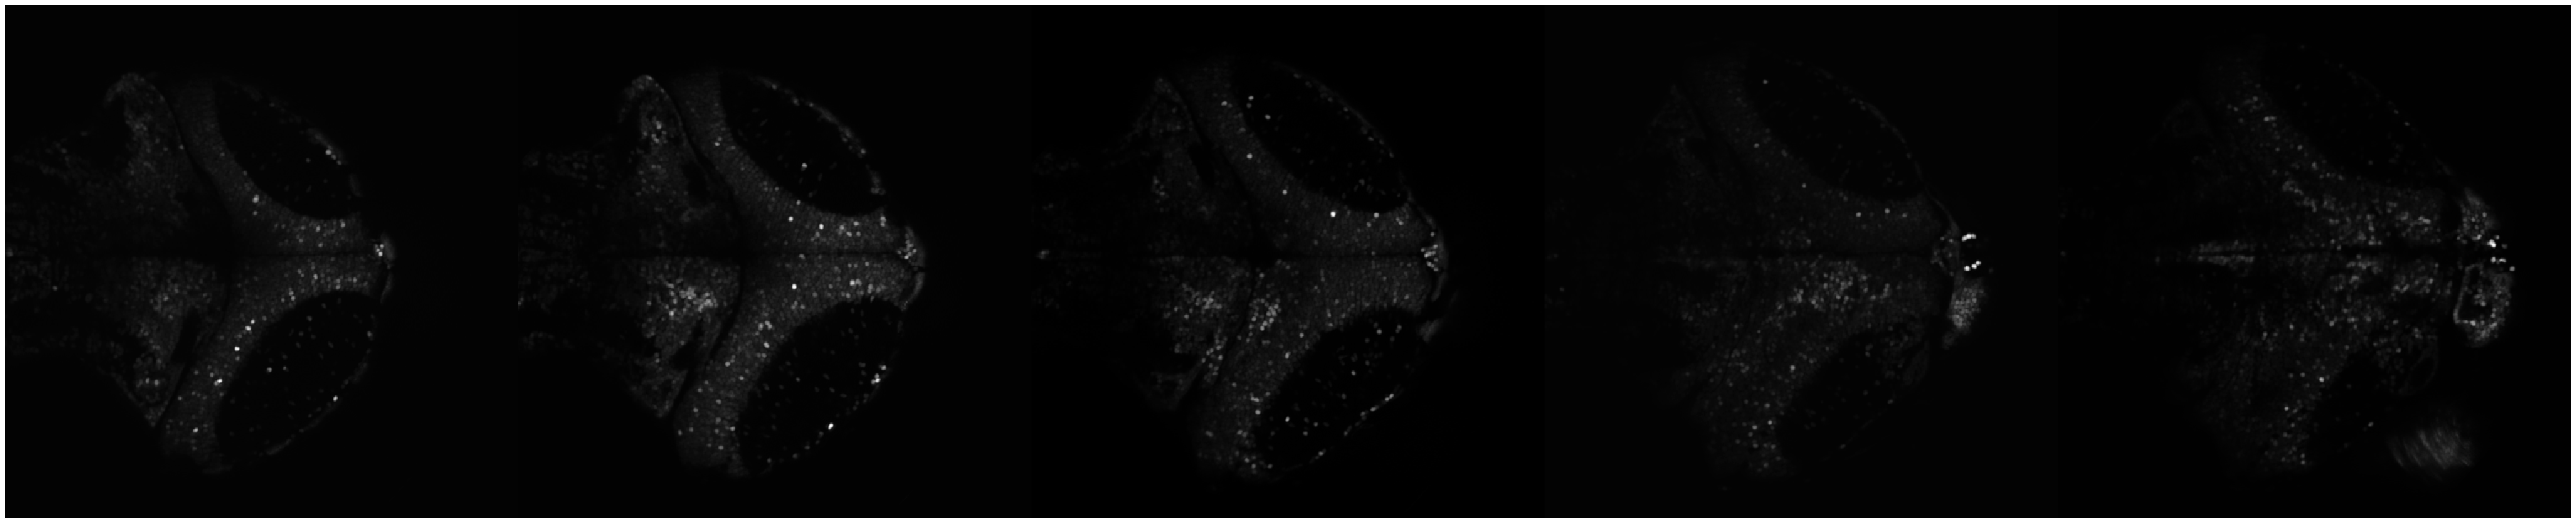

In [124]:
#Select fish to register
#-------------------------------------------------------------
experiment = 'PTZ-WILDTYPE'
disk = '/Volumes/Dominic Time Machine/'          #path to ops files
modality = '2photon'
prefix = None #Set to Yes if genotype is present in name

cond = 'BLN_' #ADD _ AT END
file = 'PTZ-WILDTYPE-02'

f, Fish, img_fold  = rfn.load_prereg(experiment, file, modality, cond, prefix, disk, Fdata)

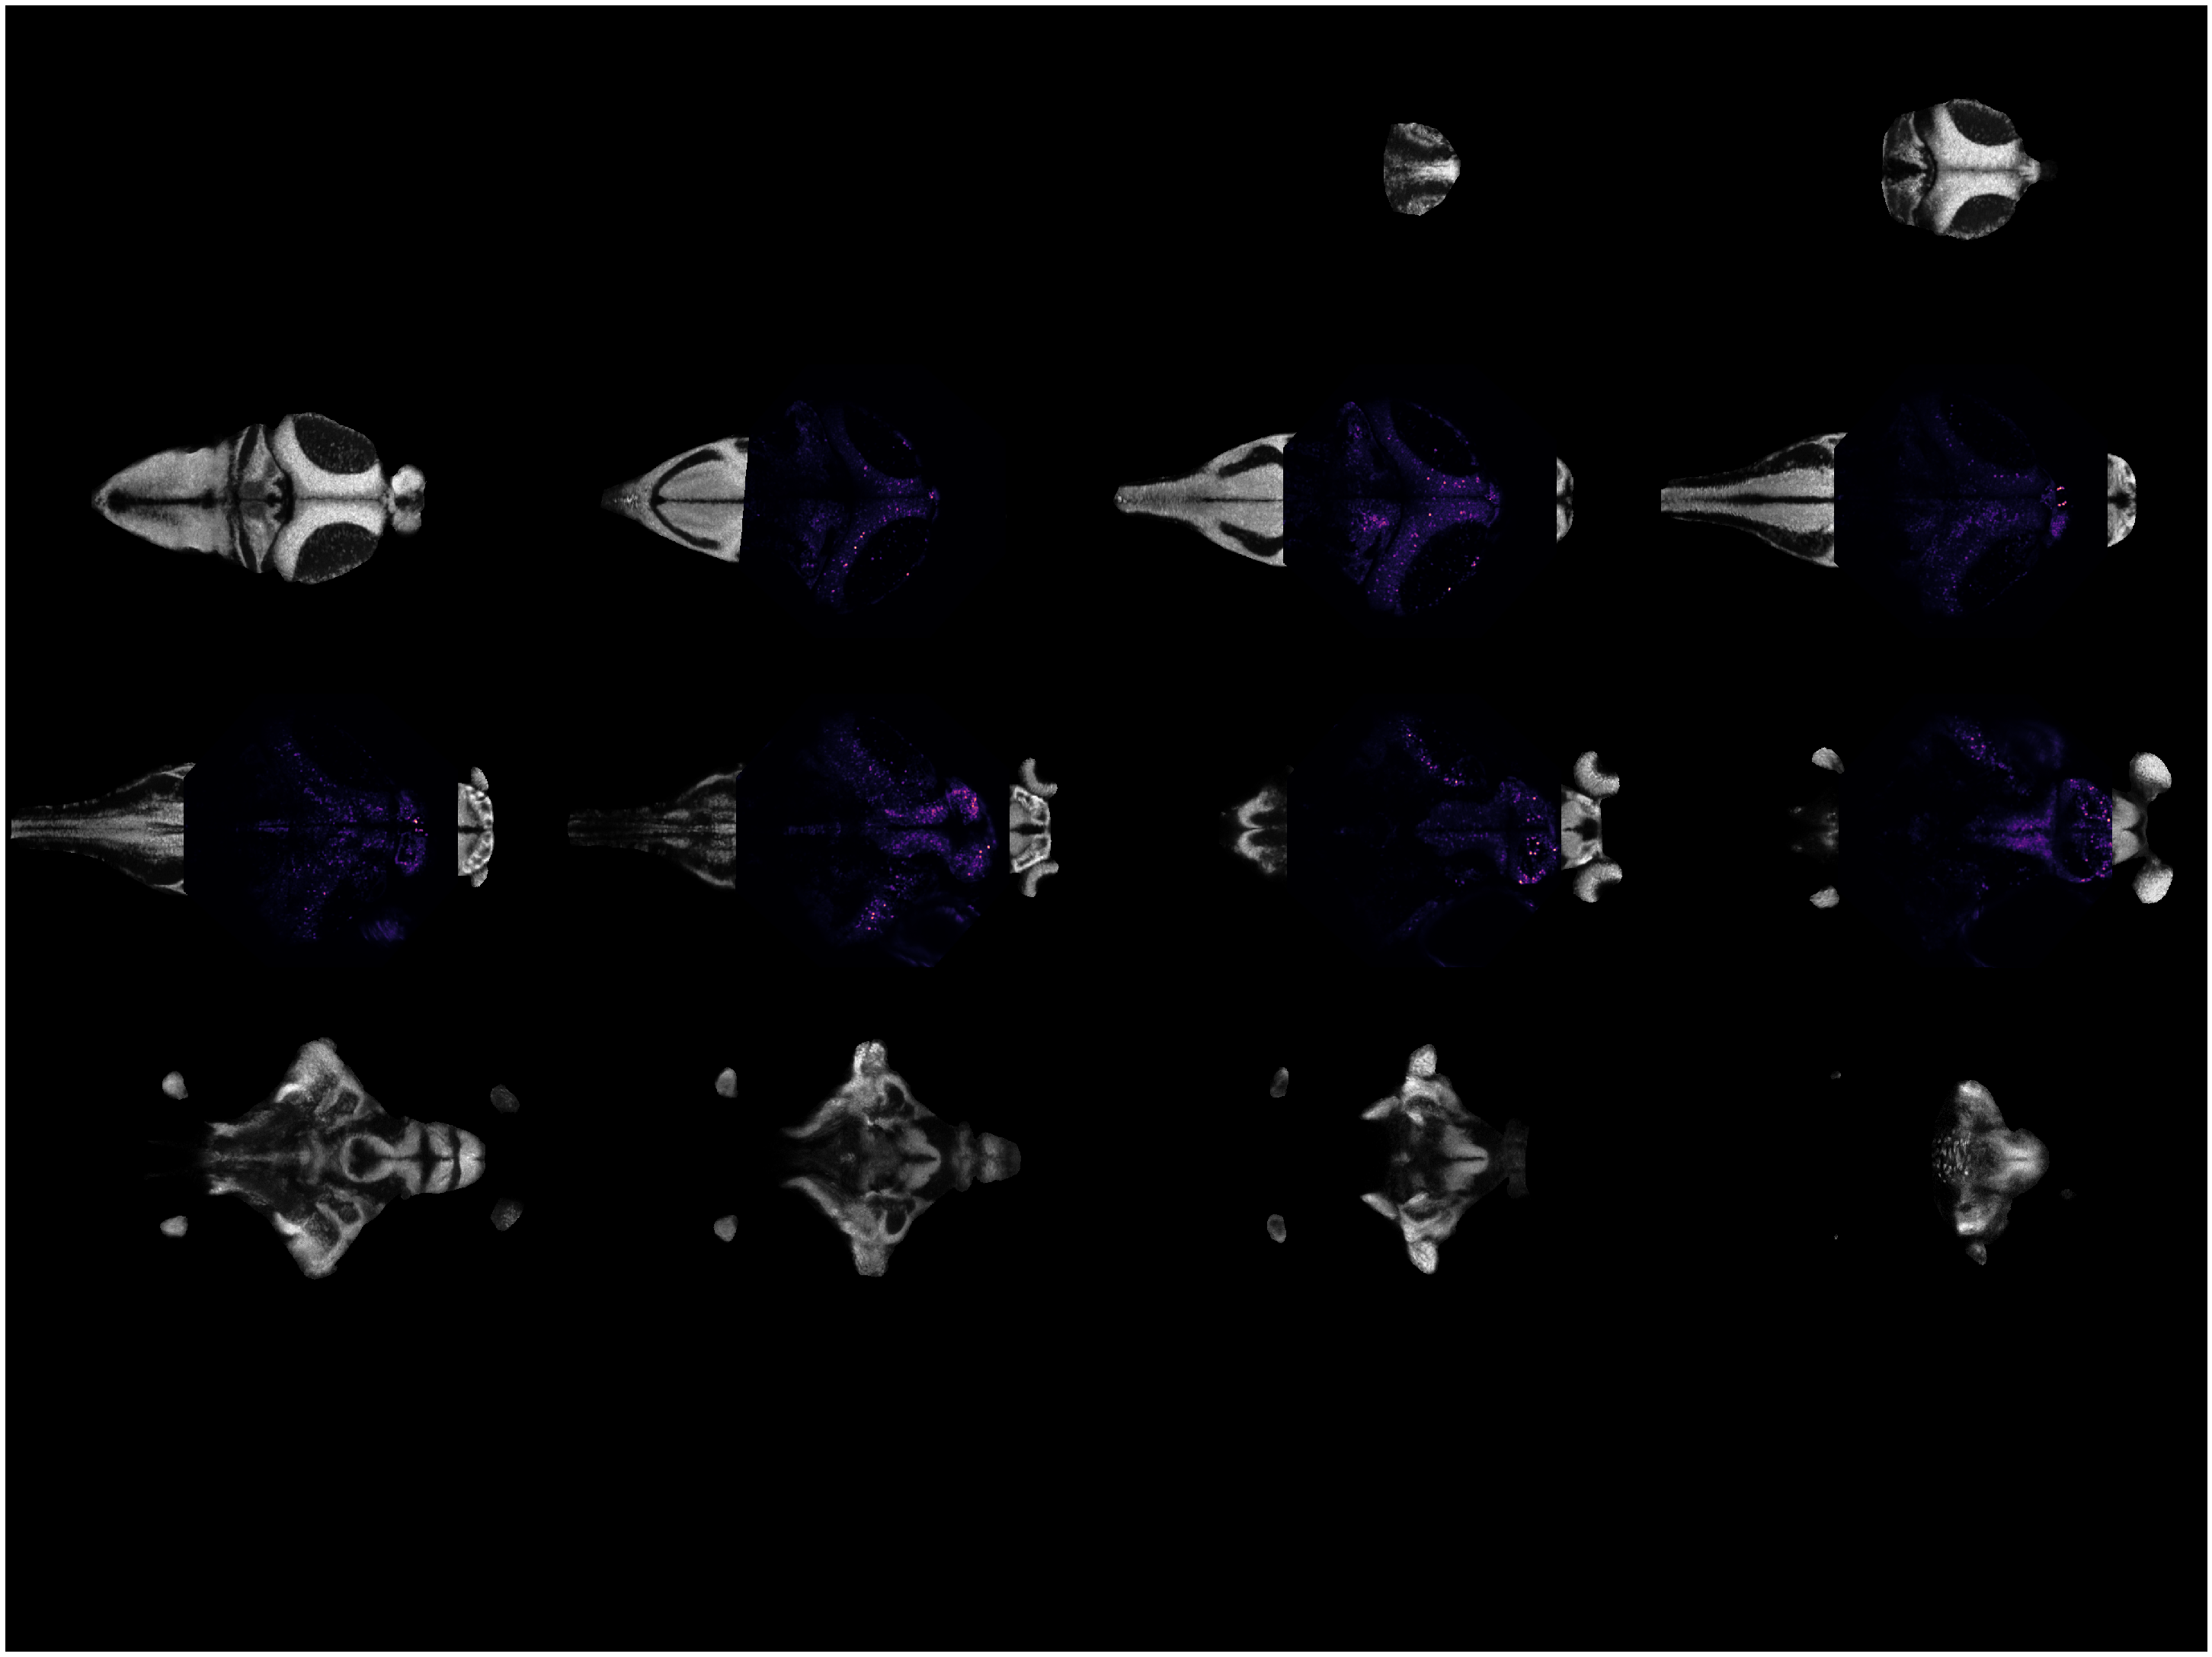

In [125]:
#Apply registration
#----------------------------------------------------------------
f_prac = ants.registration(zbb, f, type_of_transform = 'Rigid') 

#Inspect registration
rfn.fishplot(zbb,f_prac['warpedmovout'], orient = 'axial', al = 1)

# Apply registration to coordinates

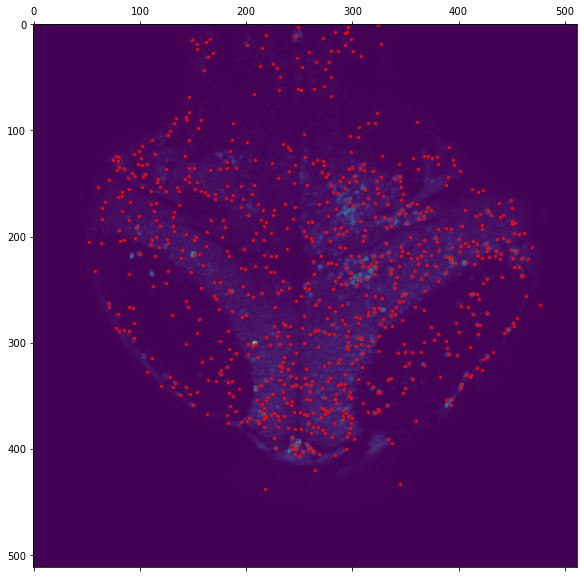

In [206]:
#apply rotation to coordinates
#----------------------------------------------------------------
xyz_rot, to_del = rfn.rotate_coords(xyz, img_fold)

#plot rotated coordinates over rotated image
#----------------------------------------------------------------
plane_num= 2
fig, ax = plt.subplots(figsize = (10,10))
ax.matshow(f[:,:,plane_num])
loc = np.where(xyz_rot[:,2] == plane_num)
ax.scatter(xyz_rot[:,0][loc],xyz_rot[:,1][loc], s = 5, c = 'red', alpha = 1)
plt.show()

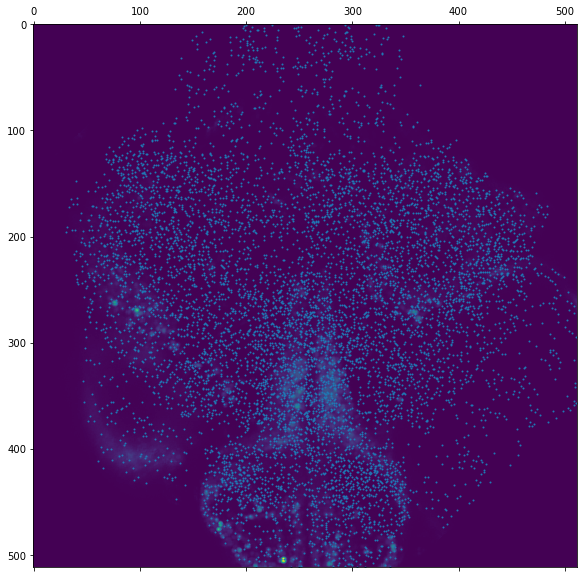

In [216]:
#Build ants image with pixels labelled by cell location
#----------------------------------------------------------------
lab_img = rfn.lab_Img(f, xyz_rot, to_del)

#Visualise reconstructed cell image over actual image
#----------------------------------------------------------------
plot = np.zeros((lab_img[:,:,0].shape))
for i in range(10):
    plot +=lab_img[:,:,i]
num = 9
fig,axarr = plt.subplots(figsize = (10,10))
axarr.matshow(f[:,:,num])
axarr.scatter(np.where(plot > 0)[1],np.where(plot > 0)[0], s = 1)
plt.show()

In [ ]:
#Apply transformation to labelled image
trans_points = ants.apply_transforms(zbb, lab_img, f_prac['fwdtransforms'], interpolator='nearestNeighbor')

In [19]:
#Generate plot to visualise 
full_plot = np.zeros((trans_points[:,:,0].shape))
for i in range(420):
    full_plot +=trans_points[:,:,i]

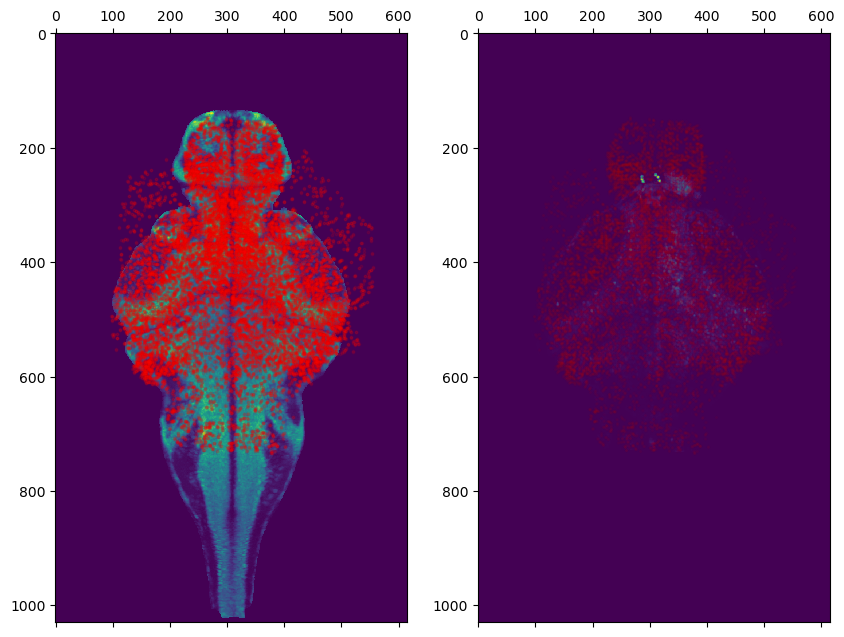

In [23]:
#Plot newly warped cell coordinates over atlas (left) and warped fish image (right)'
xnum = 150
fin_plot = full_plot
curr_warped = f_prac['warpedmovout']
curr_points = f_synra_points
old_points = dp_n

fig,axarr = plt.subplots(1,2, figsize = (10,10))
axarr[0].matshow(zbb[:,:,xnum])
axarr[0].scatter(np.where(fin_plot > 0)[1],np.where(fin_plot > 0)[0], s = 3, alpha = 0.1, c = 'red')
axarr[1].matshow(curr_warped[:,:,xnum])
axarr[1].scatter(np.where(fin_plot > 0)[1],np.where(fin_plot > 0)[0], s = 2, alpha = 0.02, c = 'red')
plt.show()


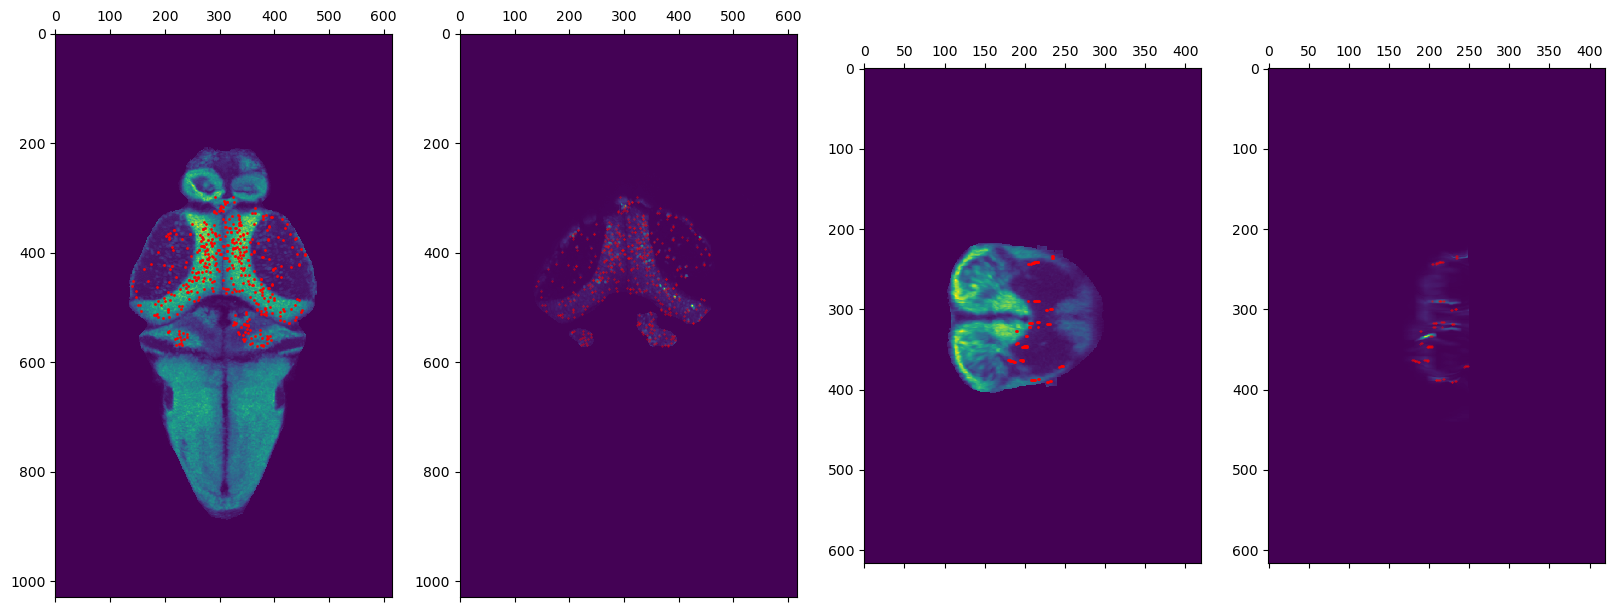

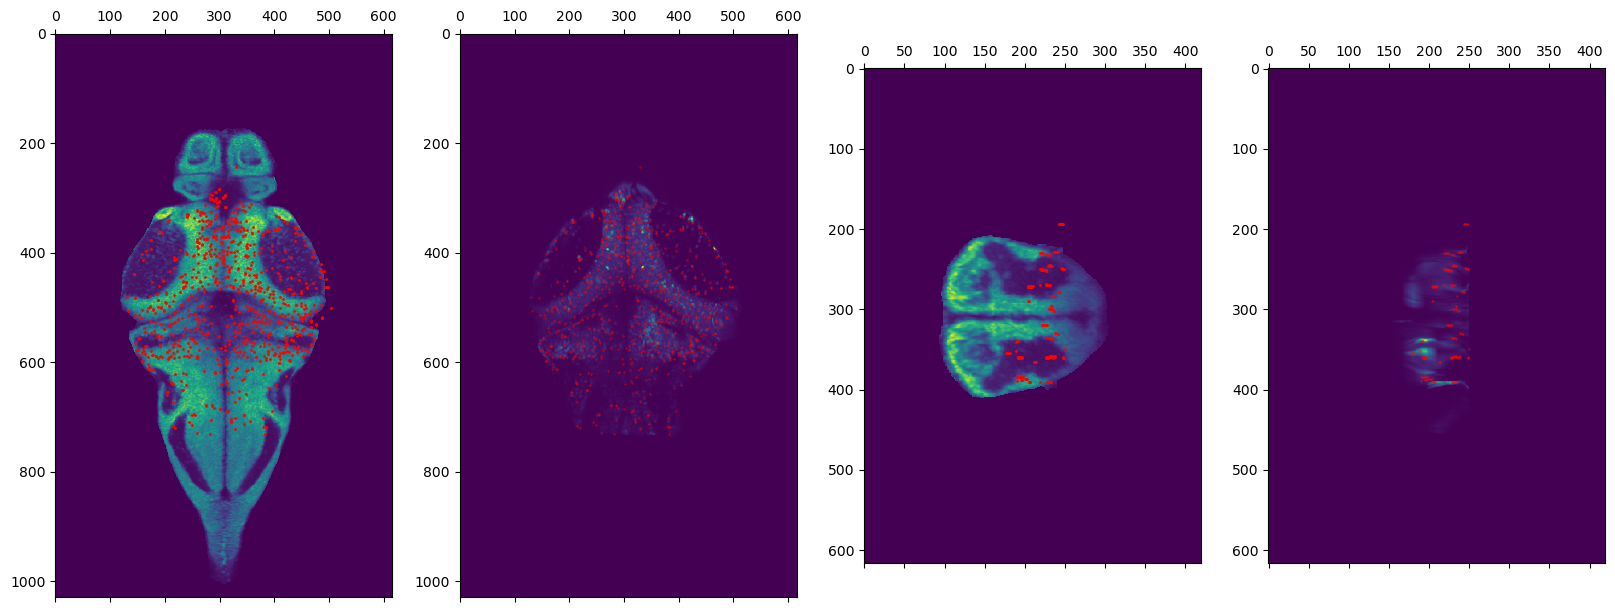

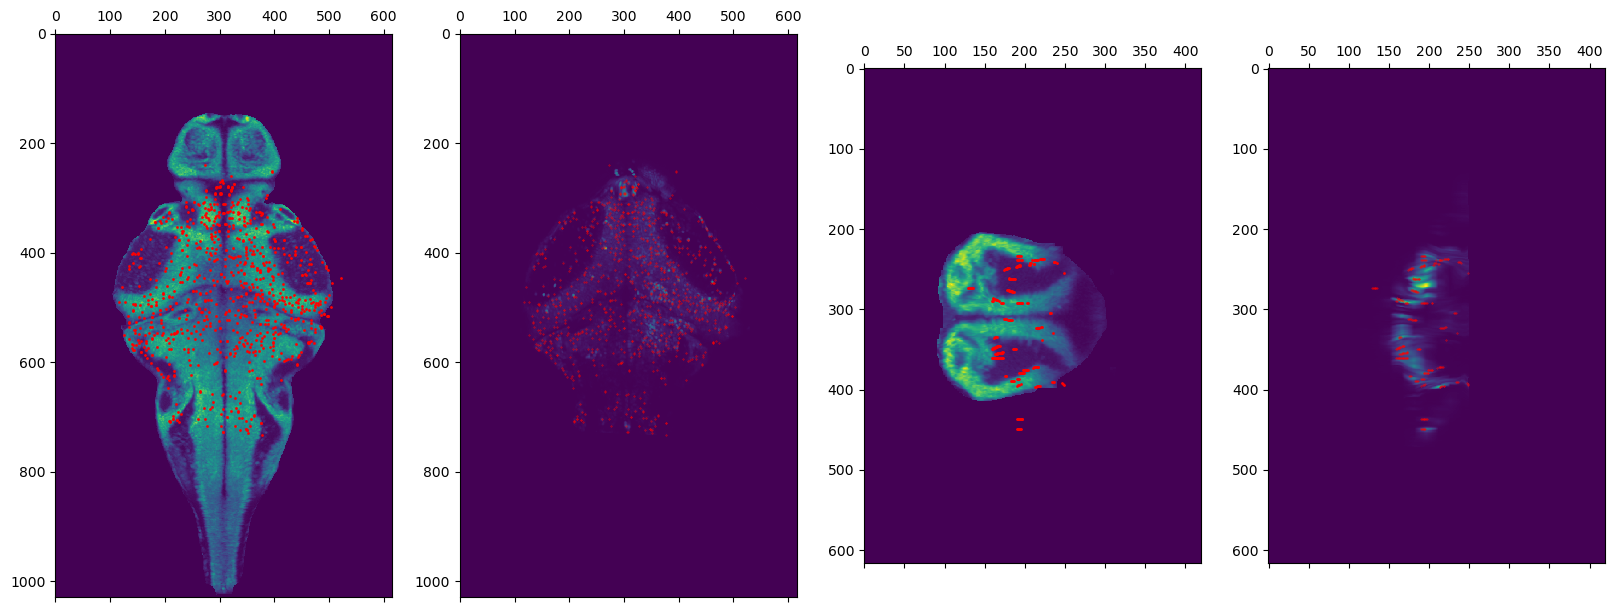

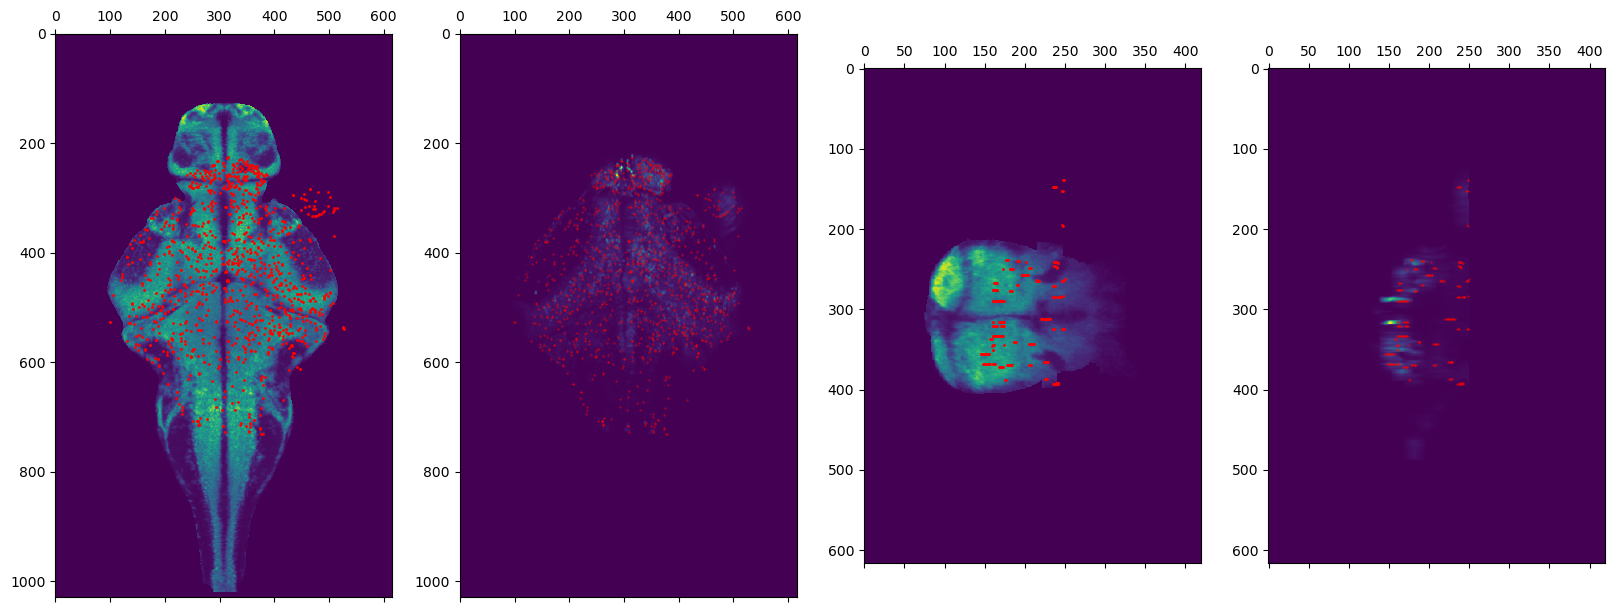

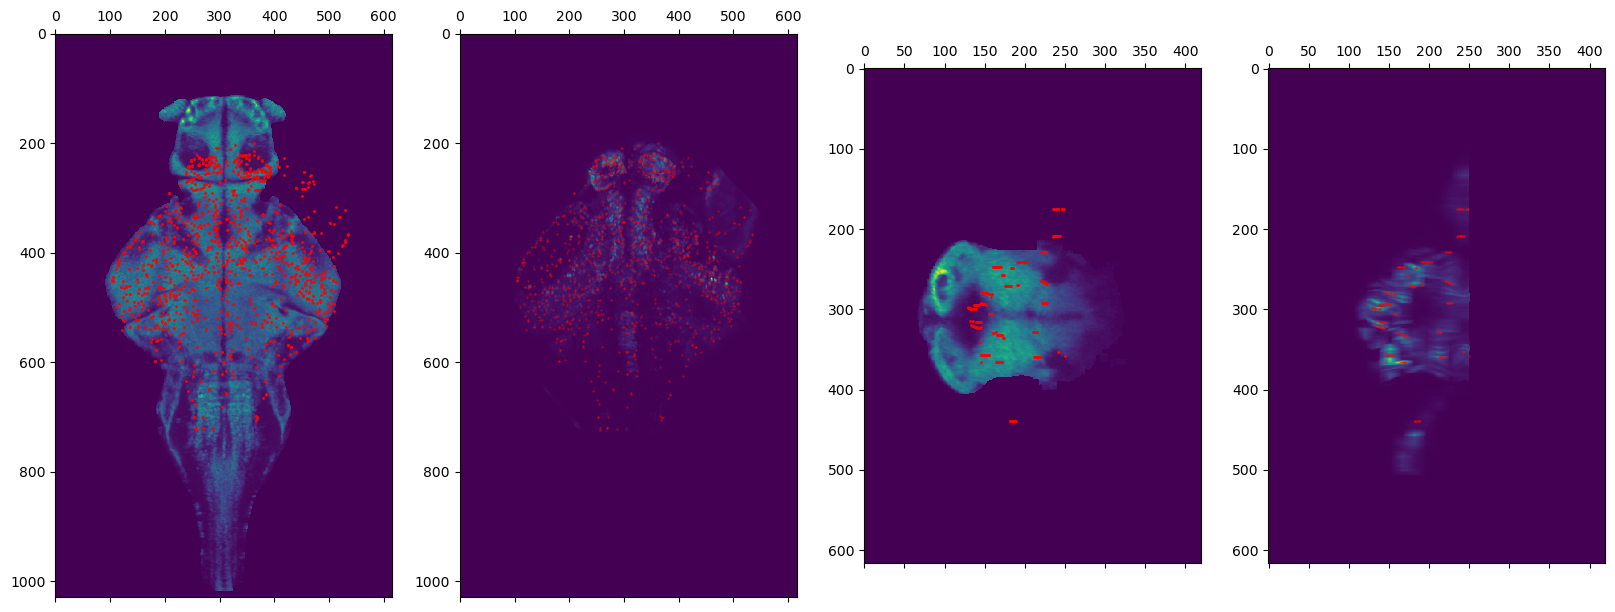

In [24]:
#Plot newly warped cell coordinates over atlas/warped fish brain, by individual planes
znumlist = np.arange(100, 200, 20)
xnumlist = np.arange(200, 300,20)

for num in range(len(znumlist)):
    fig,axarr = plt.subplots(1,4, figsize = (20,20))
    axarr[0].matshow(zbb[:,:,znumlist[num]])
    axarr[0].scatter(np.where(curr_points[:,:,znumlist[num]] > 0)[1],np.where(curr_points[:,:,znumlist[num]] > 0)[0], s = 1, c = 'red')
    axarr[1].matshow(curr_warped[:,:,znumlist[num]])
    axarr[1].scatter(np.where(curr_points[:,:,znumlist[num]] > 0)[1],np.where(curr_points[:,:,znumlist[num]] > 0)[0], s = 0.1, c = 'red')
    axarr[2].matshow(zbb[xnumlist[num],:,:])
    axarr[2].scatter(np.where(curr_points[xnumlist[num],:,:] > 0)[1],np.where(curr_points[xnumlist[num],:,:] > 0)[0], s = 1, c = 'red')
    axarr[3].matshow(curr_warped[xnumlist[num],:,:])
    axarr[3].scatter(np.where(curr_points[xnumlist[num],:,:] > 0)[1],np.where(curr_points[xnumlist[num],:,:] > 0)[0], s = 0.1, c = 'red')
    plt.show()

# Assign atlas labels

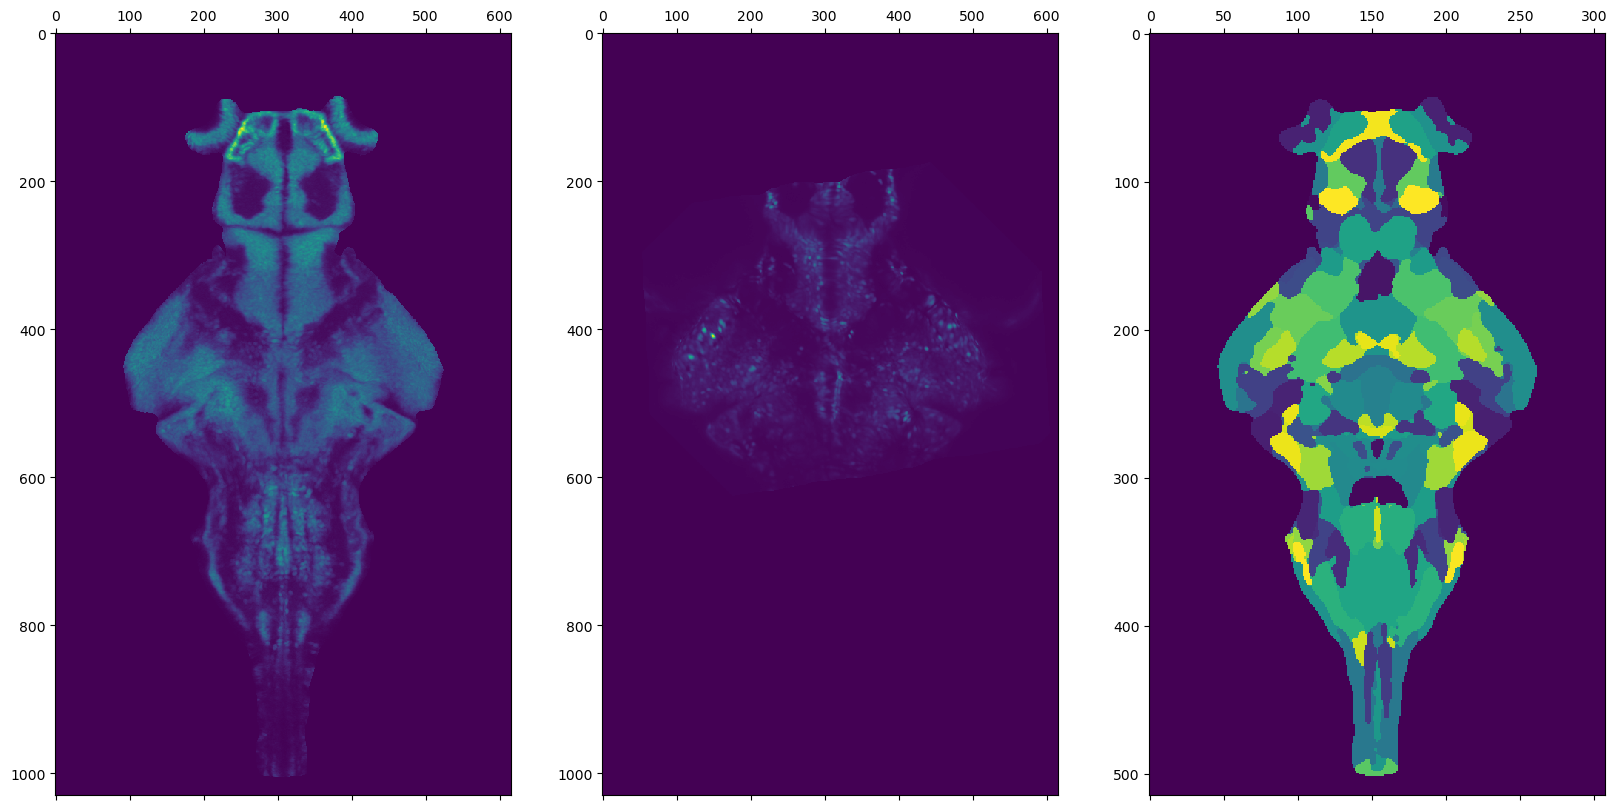

In [81]:
#Check that the registration has worked
plane_num = 200
fish = fish2ref_synra['warpedmovout']
fig,axarr = plt.subplots(1,3, figsize = (20,20))
axarr[0].matshow(zbb[:,:,plane_num])
axarr[1].matshow(fish[:,:,plane_num])
axarr[2].matshow(label[:,:,np.int(plane_num/2)])
plt.show()